In [1]:
import numpy as np
from numpy.linalg import inv
import matplotlib.pyplot as plt

## We base our first iteration on Unicycle Kinematics.
## https://www.mathworks.com/help/robotics/ug/mobile-robot-kinematics-equations.html
## x = [x,y,heading]^T
## u = [wheel_speed, heading_rate (rad/s)]^T


## Some constants
r = 0.1 # wheel radius

## Define our model
# x_dot = A*x + B*u
A = np.identity(3)
def B(r,x):
    B = np.array([[r*np.cos(x[2]), 0],
                  [r*np.sin(x[2]), 0],
                  [0, 1]])
    return B


In [2]:
## Tuning parameters
v_k = np.array([0.01,0.01,0.003]) # process noise

w_k = np.array([0.05,0.05,0.05]) # sensor noise

Q_k = np.array([[0.1,   0,   0], # model noise covariance matrix
                [  0, 0.1,   0],
                [  0,   0, 0.1]])

H_k = np.array([[1.0,  0,   0], # observation matrix
               [  0, 1.0,   0],
               [  0,  0, 1.0]])

R_k = np.array([[1.0,   0,    0], # observation/estimate noise covariance matrix
                [  0, 1.0,    0],
                [  0,    0, 1.0]])


In [3]:
## EKF function
def EKF(z_k, x_k_min_1, u_k_min_1, P_k_min_1, T):
    
    # z_k: observation vector
    # x_k_min_1: previous state estimate
    # u_k_min_1: previous input
    # P_k_min_1: previous covariance matrix
    # T: time
    
    # Prediction phase
    x_k = A @ x_k_min_1 + B(r,x_k_min_1) @ (u_k_min_1) + w_k # predicted state estimate
    
    P_k = A @ P_k_min_1 @ A.T + Q_k # updated covariance matrix (pre-correction)
    
    
    # Correction phase
    S_k = H_k @ P_k @ H_k.T + R_k
    
    y_k_hat = z_k - (H_k @ x_k + v_k) # measurement estimate
    
    K_k = P_k @ H_k.T @ inv(S_k) # near-optimal Kalman gain
    
    x_k_hat = x_k + K_k @ y_k_hat # updated state estimate prediction
    
    P_k = (np.identity(3) - K_k @ H_k) @ P_k # updated covariance matrix (post-correction)
    
    # Returning state estimate and covariance
    return x_k_hat, P_k

In [6]:
def simulate_robot():
    
    # Constants
    t_0 = 1 # time interval start
    T = 1 # total time interval
    
    # Initial values
    z_k = np.array([[4.721,0.143,0.006], # k=1
                    [9.353,0.284,0.007], # k=2
                    [14.773,0.422,0.009],# k=3
                    [18.246,0.555,0.011], # k=4
                    [22.609,0.715,0.012]])# k=5
    
    
    x_k_min_1 = np.array([0.0,0.0,0.0]) # initial state
    u_k_min_1 = np.array([10.0,1.0]) # initial input
    P_k_min_1 = np.array([[0.1, 0, 0], # initial covariance
                          [0, 0.1, 0],
                          [0, 0, 0.1]])
    
    x = []
    y = []
    
    #Iterate
    for k, z_k_obs in enumerate(z_k,start=t_0):
        
        x_k_hat, P_k = EKF(z_k_obs, x_k_min_1,u_k_min_1,P_k_min_1,T)
         
        # Get ready for the next timestep by updating the variable values
        x_k_min_1 = x_k_hat
        P_k_min_1 = P_k
        
        x.append(x_k_hat[0])
        y.append(x_k_hat[1])
    
    fig, ax = plt.subplots()

    ax.plot(x, y, linewidth=2.0)

    ax.set(xlim=(0, 8), xticks=np.arange(1, 8),
           ylim=(0, 8), yticks=np.arange(1, 8))

    plt.show()

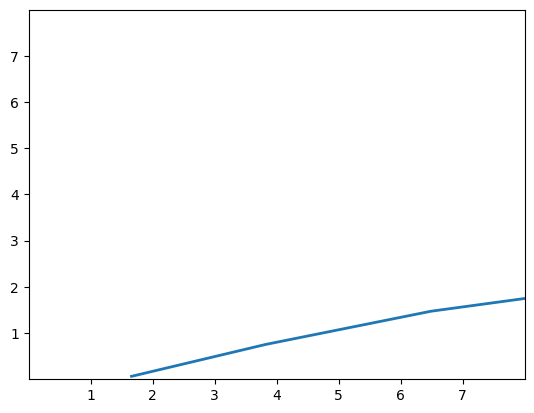

In [7]:
simulate_robot()